In [1]:
import hnswlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits, load_breast_cancer

In [2]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dim = X_train.shape[1]

In [3]:
k = 5
ef = 800
M = 48

# Handwritten digits toy example

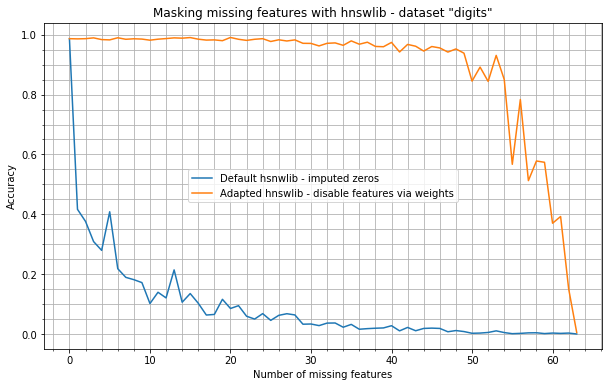

In [4]:
# Approx kNN - fitted with whole feature space
approx_knn = hnswlib.Index(space='l2', dim=dim)
approx_knn.init_index(max_elements=len(X_train), ef_construction=ef, M=M)
approx_knn.add_items(X_train, num_threads=-1)
approx_knn.set_ef(ef)

accuracy_weighting, accuracy_no_weighting = [], []
for d in range(dim):    
    # Disable randomly features
    missing_features = np.random.permutation(dim)[:d]
    available_features = np.setdiff1d(np.arange(dim), missing_features)
    
    ###########
    # Exact kNN - fitted & queried with the current subset of feature
    exact_knn = KNeighborsClassifier(n_neighbors=k).fit(X_train[:, available_features], y_train)
    exact_query = exact_knn.kneighbors(X_test[:, available_features])[1]
    
    ###########
    # HNSWLIB
    weights = np.ones(dim)
    weights[missing_features] = 0  # disable features via 0-weighting
    # Manipulate test data in order to use it with default HNSWLIB & no weighting
    X_test_ = X_test.copy()
    X_test_[:, missing_features] = 0
    # Query data with imputed values (only zeros...) or disabled features
    approx_query = approx_knn.knn_query(X_test_, k=k)[0]
    approx_query_weight = approx_knn.weighted_knn_query(X_test_, weights, k=k)[0]

    accuracy_no_weighting.append(np.mean(exact_query == approx_query))
    accuracy_weighting.append(np.mean(exact_query == approx_query_weight))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(dim), accuracy_no_weighting,label='Default hsnwlib - imputed zeros')
ax.plot(range(dim), accuracy_weighting, label='Adapted hnswlib - disable features via weights')

ax.set_title('Masking missing features with hnswlib - dataset "digits"')
ax.set_xlabel('Number of missing features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()

plt.show()

# Breast cancer toy example

In [5]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dim = X_train.shape[1]

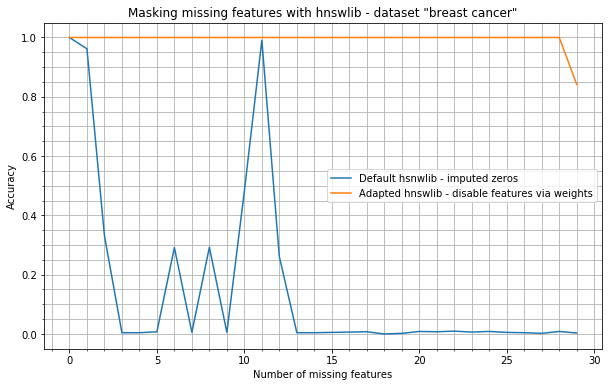

In [6]:
# Approx kNN - fitted with whole feature space
approx_knn = hnswlib.Index(space='l2', dim=dim)
approx_knn.init_index(max_elements=len(X_train), ef_construction=ef, M=M)
approx_knn.add_items(X_train, num_threads=-1)
approx_knn.set_ef(ef)

accuracy_weighting, accuracy_no_weighting = [], []
for d in range(dim):    
    # Disable randomly features
    missing_features = np.random.permutation(dim)[:d]
    available_features = np.setdiff1d(np.arange(dim), missing_features)
    
    ###########
    # Exact kNN - fitted & queried with the current subset of feature
    exact_knn = KNeighborsClassifier(n_neighbors=k).fit(X_train[:, available_features], y_train)
    exact_query = exact_knn.kneighbors(X_test[:, available_features])[1]
    
    ###########
    # HNSWLIB
    weights = np.ones(dim)
    weights[missing_features] = 0  # disable features via 0-weighting
    # Manipulate test data in order to use it with default HNSWLIB & no weighting
    X_test_ = X_test.copy()
    X_test_[:, missing_features] = 0
    # Query data with imputed values (only zeros...) or disabled features
    approx_query = approx_knn.knn_query(X_test_, k=k)[0]
    approx_query_weight = approx_knn.weighted_knn_query(X_test_, weights, k=k)[0]

    accuracy_no_weighting.append(np.mean(exact_query == approx_query))
    accuracy_weighting.append(np.mean(exact_query == approx_query_weight))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(dim), accuracy_no_weighting,label='Default hsnwlib - imputed zeros')
ax.plot(range(dim), accuracy_weighting, label='Adapted hnswlib - disable features via weights')

ax.set_title('Masking missing features with hnswlib - dataset "breast cancer"')
ax.set_xlabel('Number of missing features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()

plt.show()

# MSR
## Most following code not inside this repo, so this wont be executable - just as a reference

In [7]:
from skeleton_tools.preprocessing import Normalizer
from skeleton_tools.feature_extraction import FeatureExtractorBase, FeatureExtractorExtended
from skeleton_tools.dataset import MSR3dDataset
from sklearn.model_selection import PredefinedSplit

msr_dataset = MSR3dDataset('data/MSRAction3DSkeletonReal3D/')

In [8]:
alpha, beta = 0.85, 0.6


X, y, subject, episode, sequence_id = msr_dataset.get_data()

train_data, train_label, train_label_sequence = [], [], []
for i, (train_idx, test_idx) in enumerate(PredefinedSplit(subject<=5).split(X, y, subject), 1):
    X_train, y_train, seq_train, sub_train = X[train_idx], y[train_idx], sequence_id[train_idx], subject[train_idx]
    X_test, y_test, seq_test, sub_test = X[test_idx], y[test_idx], sequence_id[test_idx], subject[test_idx]
    print(f'Split {i:02}:\n'
          f'\t Train subjects: {np.unique(subject[train_idx])}\t test subjects: {np.unique(subject[test_idx])}\n'
          f'\t Train samples: {len(train_idx):8}\t test samples: {len(test_idx):8}')
    normalizer = Normalizer(skeleton_type='MSR').fit(X_train)
    feature_extractor = FeatureExtractorBase(alpha, beta).fit()

    # Sequence-wise preprocessing & feature extraction
    X_train = np.concatenate([feature_extractor.transform(normalizer.transform(X_train[seq_train==seq]))
                              for seq in np.unique(seq_train)])
    # Preprocessing & feature extraction  
    X_test = np.concatenate([feature_extractor.transform(normalizer.transform(X_test[seq_test==seq]))
                              for seq in np.unique(seq_test)]) 
    break
dim = X_train.shape[1]

Split 01:
	 Train subjects: [1 2 3 4 5]	 test subjects: [ 6  7  8  9 10]
	 Train samples:    10197	 test samples:    11306


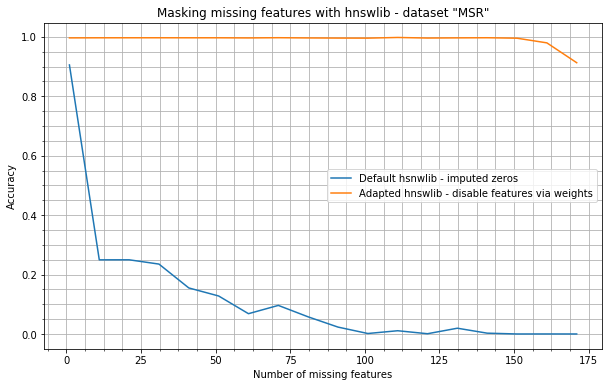

In [9]:
# Approx kNN - fitted with whole feature space
approx_knn = hnswlib.Index(space='l2', dim=dim)
approx_knn.init_index(max_elements=len(X_train), ef_construction=ef, M=M)
approx_knn.add_items(X_train, num_threads=-1)
approx_knn.set_ef(ef)

accuracy_weighting, accuracy_no_weighting = [], []
step = 10
for d in range(1, dim, step):    
    # Disable randomly features
    missing_features = np.random.permutation(dim)[:d]
    available_features = np.setdiff1d(np.arange(dim), missing_features)
    
    ###########
    # Exact kNN - fitted & queried with the current subset of feature
    exact_knn = KNeighborsClassifier(n_neighbors=k).fit(X_train[:, available_features], y_train)
    exact_query = exact_knn.kneighbors(X_test[:, available_features])[1]
    
    ###########
    # HNSWLIB
    weights = np.ones(dim)
    weights[missing_features] = 0  # disable features via 0-weighting
    # Manipulate test data in order to use it with default HNSWLIB & no weighting
    X_test_ = X_test.copy()
    X_test_[:, missing_features] = 0
    # Query data with imputed values (only zeros...) or disabled features
    approx_query = approx_knn.knn_query(X_test_, k=k)[0]
    approx_query_weight = approx_knn.weighted_knn_query(X_test_, weights, k=k)[0]

    accuracy_no_weighting.append(np.mean(exact_query == approx_query))
    accuracy_weighting.append(np.mean(exact_query == approx_query_weight))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(1, dim, step), accuracy_no_weighting,label='Default hsnwlib - imputed zeros')
ax.plot(range(1, dim, step), accuracy_weighting, label='Adapted hnswlib - disable features via weights')

ax.set_title('Masking missing features with hnswlib - dataset "MSR"')
ax.set_xlabel('Number of missing features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()

plt.show()